In [1]:
import cv2
import matplotlib.pyplot as plt
import json
import os
import pandas as pd
import numpy as np
import seaborn as sns
from pandas.io.json import json_normalize
from sklearn.model_selection import train_test_split
from sklearn.cluster import MiniBatchKMeans

from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from skimage.transform import resize

In [ ]:
#1.Extractions des keypoints + dico creation

i=1;

X = [];
Y = [];
dico = [];

choicePath = "train";

# Initiate SIFT (or ORB) detector
orb = cv2.ORB_create()
sift = cv2.xfeatures2d.SIFT_create()

files = os.listdir("./"+choicePath+"")
for file in files:
    if file.endswith('.jpg'):
        img = cv2.imread("./"+choicePath+"/"+file,cv2.COLOR_RGB2GRAY)
        img = cv2.resize(img, (100,100))
        
        print("Pourcentage effectué : "+str(i/(len(files)/3)*100)+"% (Fichier "+str(i)+" sur "+str(len(files)/3)+")")
        i = i+1
        
        (kp, des) = sift.detectAndCompute(img, None)
        
        for d in des:
            dico.append(d)
            
        X.append(file);
        nameFile = file.split('.')[0];
        for file_class in files:
            nameFileAutre = file_class.split('.')[0];
            if nameFile==nameFileAutre and file_class.endswith('.json'):
                fichierSrc = open("./"+choicePath+"/"+file_class, "r");
                contenu = fichierSrc.read();
                monJson = json.loads(contenu)
                Y.append(monJson["Image"]["Species"])
                break;

In [3]:
#SIFT Algorithm

#Test
#100x100 accuracy:  0.302158273381295
#200x200 accuracy:  0.2892086330935252
#500x500 accuracy:  0.3079136690647482
#1000x1000 accuracy:  0.30503597122302156

#ORB Algorithm

#Test
#100x100 accuracy: 0.19424460431654678
#1000x1000 accuracy: 0.1985611510791367

In [4]:
# on a bien une classe par image !
if(len(X) == len(Y)):
    print("OK")
else:
    print("KO")
    
# liste des espèces
species = list(set(Y))
species.sort()

OK


In [ ]:
#2.Clustering

k = np.size(species) * 10

batch_size = np.size(os.listdir("./"+choicePath+"")) #normalement *3 mais le dossier train contient aussi les .json et .xml
kmeans = MiniBatchKMeans(n_clusters=k, batch_size=batch_size, verbose=1).fit(dico)


In [ ]:
#3.Création des histogrammes

i=1;

kmeans.verbose = False

histo_list = []

for file in files:
    if file.endswith('.jpg'):
        img = cv2.imread("./"+choicePath+"/"+file) 
        kp, des = sift.detectAndCompute(img, None)
        
        print("Pourcentage effectué : "+str(i/(len(files)/3)*100)+"% (Fichier "+str(i)+" sur "+str(len(files)/3)+")")
        i = i+1

        histo = np.zeros(k)
        nkp = np.size(kp)
        
        j=1;

        for d in des:
            idx = kmeans.predict([d])
            histo[idx] += 1/nkp # pour normaliser les histogrammes

        histo_list.append(histo)
        

In [10]:
# Début de la classification sur le jeu de test

from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import ComplementNB

X =np.asarray(histo_list);
y = np.asarray(Y);

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split( X_train, y_train, test_size=0.25, random_state=42, stratify=y_train)


scoring = 'accuracy'
models =[]

models.append(('KNN', KNeighborsClassifier()))
models.append(('GaussianNB', GaussianNB())) 
models.append(('MultinomialNB', MultinomialNB()))
models.append(('ComplementNB', ComplementNB()))
models.append(('SGDClassifier', SGDClassifier()))
models.append(('LinearSVC', LinearSVC()))



results = []
names = []
for name,model in models:
    kfold = KFold(n_splits=15, shuffle=True)
    cv_results = cross_val_score(model, X, y, cv=kfold, scoring=scoring)
    #pour avoir les paramètres utilisés dans le modèle enlever commentaire ligne suivante
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

KNN: 0.206674 (0.032642)
GaussianNB: 0.295914 (0.036448)
MultinomialNB: 0.037407 (0.017512)
ComplementNB: 0.173839 (0.035657)
SGDClassifier: 0.080034 (0.041475)
LinearSVC: 0.200332 (0.018203)


[Text(0, 0, 'KNN'),
 Text(0, 0, 'GaussianNB'),
 Text(0, 0, 'MultinomialNB'),
 Text(0, 0, 'ComplementNB'),
 Text(0, 0, 'SGDClassifier'),
 Text(0, 0, 'LinearSVC')]

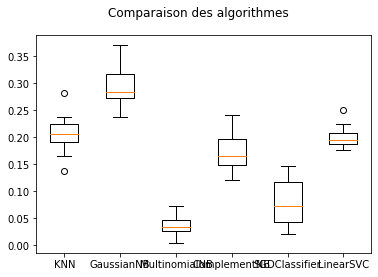

In [11]:
fig = plt.figure()
fig.suptitle('Comparaison des algorithmes')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)

In [12]:
classifiers = {
    'GaussianNB': GaussianNB(),
    'MultinomialNB':MultinomialNB(),
    'ComplementNB': ComplementNB(),
    'KNN': KNeighborsClassifier(),
    'SGDClassifier': SGDClassifier(),
    'LinearSVC': LinearSVC()
}

params = {'MultinomialNB':[{'fit_prior': [True,False]},
                            {'alpha':[1.0]}
                          ],
          'GaussianNB': [{}],
          'ComplementNB': [{'norm':[True,False]}],
          'KNN': [{}],
          'SGDClassifier': [{}],
          'LinearSVC': [{}]
         }



import torch


class Result:
     def __init__(self,name, score, parameters):
         self.name = name
         self.score = score
         self.parameters = parameters
     def __repr__(self):
         return repr((self.name, self.score, self.parameters))

       
results = []
names=[]
for key,value in classifiers.items():
    gd_sr = GridSearchCV(estimator=value,  
                     param_grid=params[key],
                     scoring='accuracy',
                     cv=5,
                     n_jobs=1,
                     iid=True)
    gd_sr.fit(X_train, y_train)  
    result=Result(key,gd_sr.best_score_,gd_sr.best_estimator_)
    results.append(result)   
    names.append("sdf")
    
    
    
results=sorted(results, key=lambda result: result.score, reverse=True) 

print ('Le meilleur resultat : \n')
print ('Classifier : ',results[0].name, 
       ' score %0.2f' %results[0].score, 
       ' avec ',results[0].parameters,'\n')

print ('Tous les résultats : \n')
for result in results:
    print ('Classifier : ',result.name, 
           ' score %0.2f' %result.score, 
           ' avec ',result.parameters,'\n')
    
#On enregistre le modèle
PATH = './bestModel.pth'
torch.save(gd_sr.best_estimator_, PATH)

Le meilleur resultat : 

Classifier :  GaussianNB  score 0.28  avec  GaussianNB(priors=None, var_smoothing=1e-09) 

Tous les résultats : 

Classifier :  GaussianNB  score 0.28  avec  GaussianNB(priors=None, var_smoothing=1e-09) 

Classifier :  KNN  score 0.18  avec  KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform') 

Classifier :  ComplementNB  score 0.17  avec  ComplementNB(alpha=1.0, class_prior=None, fit_prior=True, norm=False) 

Classifier :  LinearSVC  score 0.17  avec  LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0) 

Classifier :  MultinomialNB  score 0.10  avec  MultinomialNB(alpha=1.0, class_prior=None, fit_prior=False) 

Classifier :  SGDClassifier  score 0.08  a


 accuracy:  0.2935251798561151 


 matrice de confusion 
 [[6 0 0 ... 0 0 0]
 [0 5 0 ... 0 0 0]
 [0 1 0 ... 1 0 0]
 ...
 [0 0 0 ... 3 0 1]
 [0 0 0 ... 0 6 0]
 [0 0 0 ... 2 0 3]]

                                                          precision    recall  f1-score   support

                                Achillea millefolium L.       0.46      0.50      0.48        12
                                   Aconitum napellus L.       0.24      0.42      0.30        12
Anacamptis morio (L.) R.M.Bateman, Pridgeon & M.W.Chase       0.00      0.00      0.00        10
                      Anacamptis pyramidalis (L.) Rich.       0.00      0.00      0.00        17
                                      Anemone alpina L.       0.40      0.20      0.27        10
                                    Anemone hepatica L.       0.40      0.20      0.27        10
                                    Anemone nemorosa L.       0.27      0.27      0.27        11
                                  Aquilegi

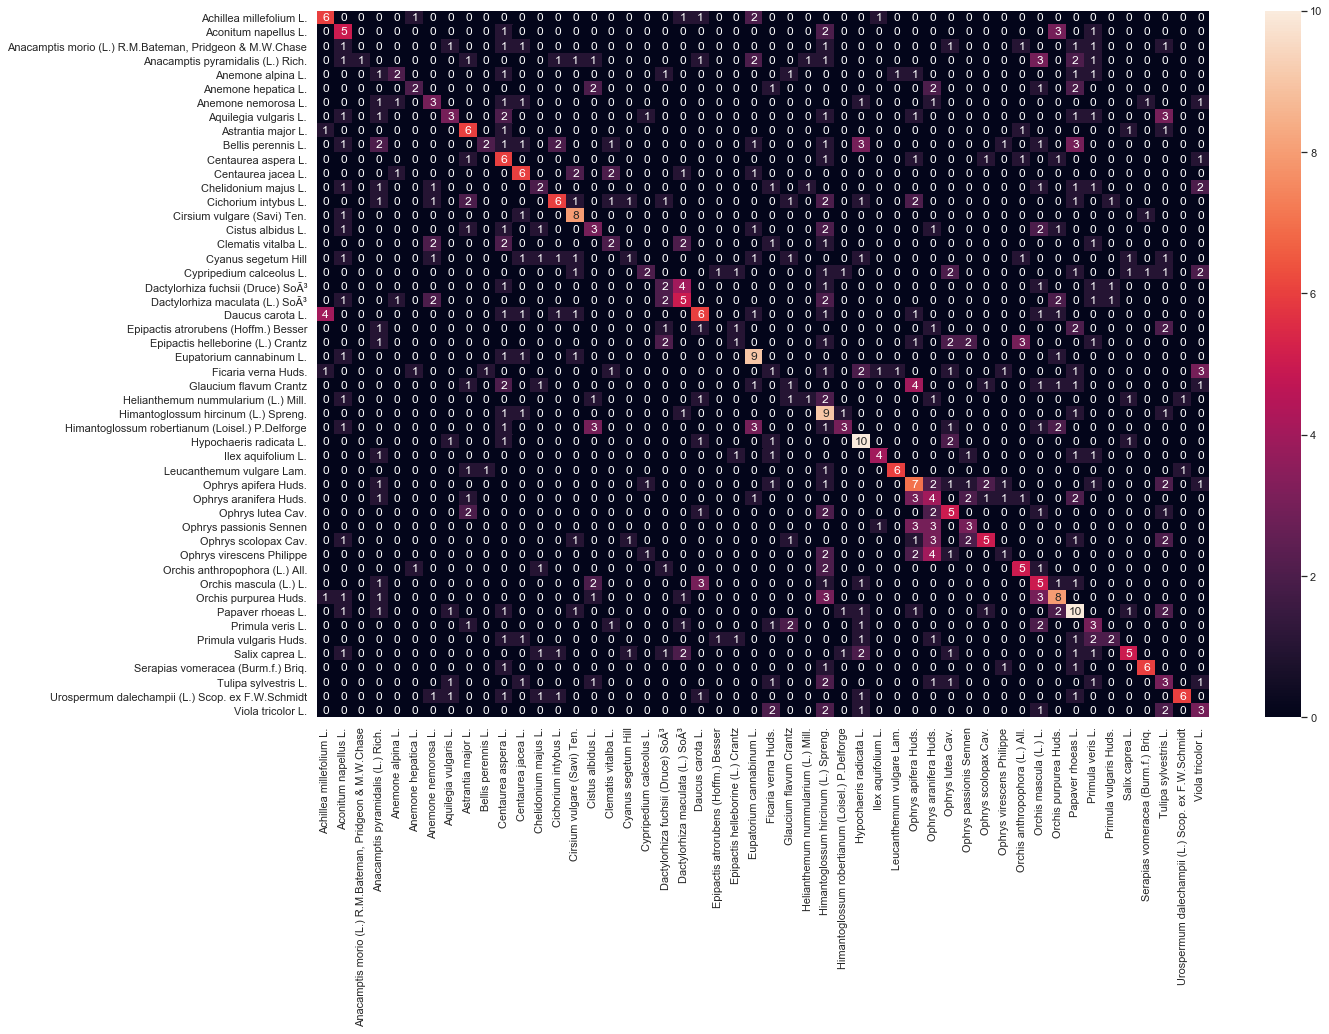

In [18]:
# Validation

PATH = 'bestModel.pth'
our_model = torch.load(PATH)

clf = classifiers[results[0].name]
clf.fit(X_train, y_train)

result = clf.predict(X_val)
print('\n accuracy: ', accuracy_score(result, y_val),'\n')
conf = confusion_matrix(y_val, result)
print ('\n matrice de confusion \n',conf)
print ('\n',classification_report(y_val, result))

plt.figure(figsize=(20, 13))
sns.set(font_scale=1)
sns.heatmap(conf, annot=True, xticklabels= species, yticklabels= species)

# correction du bug qui coupé le haut et le bas de la matrice de confusion
b, t = plt.ylim() 
b += 0.5 
t -= 0.5 
plt.ylim(b, t)
plt.show()